## Essencial Functions and Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tifffile as tiff
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score


## Read data

In [2]:
from pathlib import Path
import numpy as np
import tifffile as tiff
from difflib import get_close_matches

# Main dataset directory
dataset_dir = Path('spotlite_dataset_loca1_date1_dir1')

images_dir = dataset_dir / 'images'
masks_dir = dataset_dir / 'masks'

assert images_dir.exists(), f"Image folder not found: {images_dir}"
assert masks_dir.exists(), f"Mask folder not found: {masks_dir}"

# Collect all image and mask files (multiple extensions)
image_paths = sorted(
    [*images_dir.glob('*.tif'), *images_dir.glob('*.tiff')],
    key=lambda p: p.stem
)
mask_paths = sorted(
    [*masks_dir.glob('*.tif'), *masks_dir.glob('*.tiff'),
     *masks_dir.glob('*.png'), *masks_dir.glob('*.jpg')],
    key=lambda p: p.stem
)

# Dictionary of masks by base name
mask_dict = {p.stem: p for p in mask_paths}
unused_masks = set(mask_dict.keys())

imgs_array, masks_array = [], []

for img_path in image_paths:
    stem = img_path.stem
    mask_path = None

    # 1) Exact match
    if stem in mask_dict:
        mask_path = mask_dict[stem]
        unused_masks.discard(stem)
    else:
        # 2) Approximate match
        candidates = get_close_matches(stem, mask_dict.keys(), n=1, cutoff=0.6)
        if candidates:
            sel = candidates[0]
            mask_path = mask_dict[sel]
            unused_masks.discard(sel)
        else:
            # 3) No match found; just notify and skip
            print(f"Warning: no mask found for {img_path.name}; skipping.")
            continue

    # Read image and mask
    img = tiff.imread(str(img_path))
    msk = tiff.imread(str(mask_path))

    # Check dimensions
    if img.shape[:2] != msk.shape:
        raise ValueError(
            f"Incompatible dimensions: {img_path.name} {img.shape[:2]} vs "
            f"{mask_path.name} {msk.shape}"
        )

    imgs_array.append(img)
    masks_array.append(msk)

# Remaining masks
if unused_masks:
    print("Warning: these masks were not used (no corresponding image):")
    for s in sorted(unused_masks):
        print("  ", s)

# Stack arrays
imgs = np.stack(imgs_array, axis=0)   # (N, H, W, C)
masks = np.stack(masks_array, axis=0)  # (N, H, W)

print(f'Final: {len(imgs)} pairs loaded.')
print(f'Shape of imgs: {imgs.shape}')
print(f'Shape of masks: {masks.shape}')


Final: 391 pairs loaded.
Shape of imgs: (391, 512, 512, 4)
Shape of masks: (391, 512, 512)


## Convert labels in masks

In [3]:
# Convert labels in masks from 0, 3, 4 to 0, 1, 2
# where 0 is background, 1 is class 1, and 2 is class
# def remap_mask(mask):
#     if not torch.is_tensor(mask):
#         mask = torch.from_numpy(mask)
#     remapped = torch.zeros_like(mask)
#     remapped[mask == 0] = 0
#     remapped[mask == 3] = 1
#     remapped[mask == 4] = 2
#     return remapped.long()

# masks = remap_mask(masks)

# print(f'shape of remapped masks: {masks.shape}')

np.unique_labels = np.unique(masks)
print(f'Unique labels in masks: {np.unique_labels}')

Unique labels in masks: [0 1 2 3 4 5]


## Extract features and labels

In [9]:
from skimage.color import rgb2hsv, rgb2lab

N, H, W, C = imgs.shape
X = imgs.reshape(-1, C)       # shape = (N*H*W, 4)
y = masks.reshape(-1)         # shape = (N*H*W,)

# NDVI = (NIR - R) / (NIR + R)
# [R, G, B] → check classic visual coupling

# [G, NIR, NDVI] → check if NDVI helps separate vegetation
# [NDVI, GNDVI, NIR] → check separation by indices
# [H, S, V] or [L, A, B] if converted to HSV or LAB

R = X[:, 0]
G = X[:, 1]
B = X[:, 2]
NIR = X[:, 3]

NDVI = (NIR - R) / (NIR + R + 1e-5)
GNDVI = (NIR - G) / (NIR + G + 1e-5)
NDWI = (G - NIR) / (G + NIR + 1e-5) 

# Stack RGB normalized to [0, 1]
rgb = np.stack([R, G, B], axis=1).astype(np.float32)
rgb_norm = (rgb - rgb.min(0)) / (rgb.max(0) - rgb.min(0) + 1e-5)  # normalization per channel

# Convert to HSV and LAB
hsv = rgb2hsv(rgb_norm.reshape(-1, 1, 3)).reshape(-1, 3) 
lab = rgb2lab(rgb_norm.reshape(-1, 1, 3)).reshape(-1, 3)

# Decompor HSV
Hue = hsv[:, 0]
Saturation = hsv[:, 1]
Value = hsv[:, 2]

# Decompor LAB
L = lab[:, 0]
A = lab[:, 1]
B_lab = lab[:, 2] 

X = np.stack([
    R, G, B,           # 3 canais RGB
    NIR,               # 1 canal NIR
    NDVI, GNDVI, NDWI,  # 3 índices espectrais
    L, A, B_lab,       # 3 canais LAB
    Hue, Saturation, Value  # 3 canais HSV
], axis=1)  # total: 13 features

print(f'shape of X: {X.shape}')
print(f'shape of y: {y.shape}')

# (Opcional) amostragem para acelerar treino
# idx = np.random.choice(len(y), size=100000, replace=False)
# X, y = X[idx], y[idx]

shape of X: (102498304, 13)
shape of y: (102498304,)


## Check Inbalance

Classe 0: 95,642,115 pixels (93.31%)
Classe 1: 4,364,695 pixels (4.26%)
Classe 2: 434,765 pixels (0.42%)
Classe 3: 687,567 pixels (0.67%)
Classe 4: 1,338,296 pixels (1.31%)
Classe 5: 30,866 pixels (0.03%)
   class    counts    percent
0      0  95642115  93.310924
1      1   4364695   4.258309
2      2    434765   0.424168
3      3    687567   0.670808
4      4   1338296   1.305676
5      5     30866   0.030114


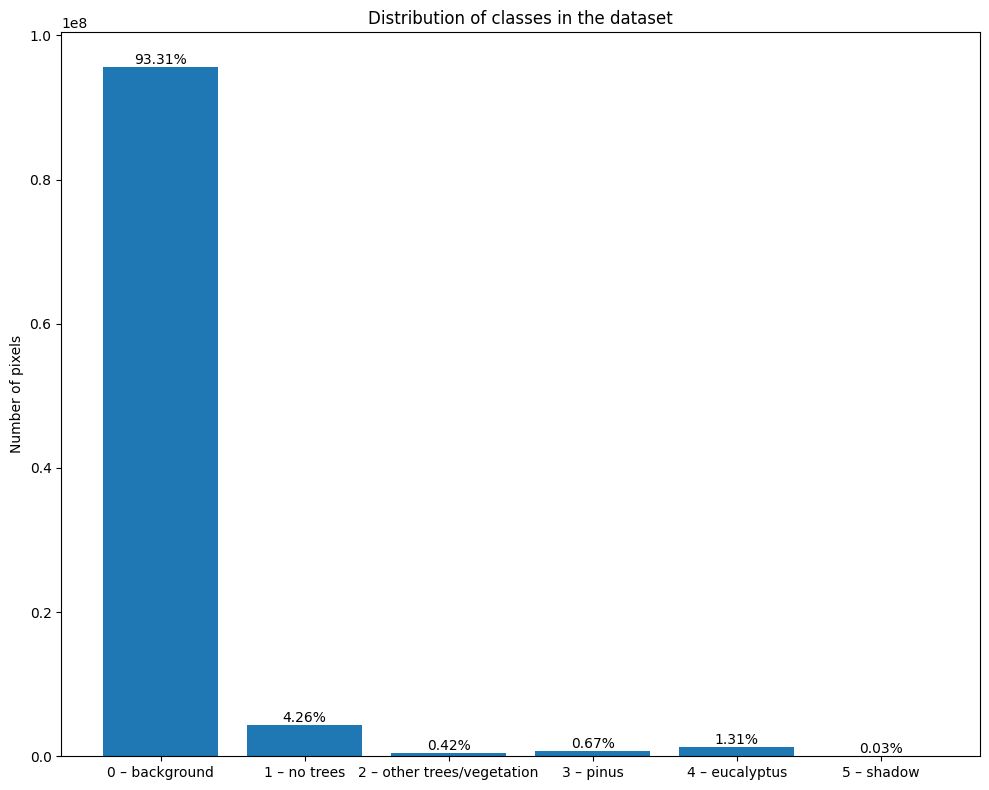

In [10]:
y = np.array(y)

y_flat = y.reshape(-1)
total_pixels = y_flat.size
classes, counts = np.unique(y_flat, return_counts=True)

for cls, ct in zip(classes, counts):
    pct = ct / total_pixels * 100
    print(f"Classe {cls}: {ct:,} pixels ({pct:.2f}%)")

df_dist = pd.DataFrame({
    "class":   classes,
    "counts":  counts,
    "percent": counts / total_pixels * 100
})
print(df_dist)

class_names = {
    0: "background",
    1: "no trees",
    2: "other trees/vegetation",
    3: "pinus",
    4: "eucalyptus",
    5: "shadow"  
}
x_labels = [f"{cls} – {class_names[cls]}" for cls in df_dist['class']]

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.bar(df_dist['class'], df_dist['counts'])

ax.set_ylabel('Number of pixels')
ax.set_title('Distribution of classes in the dataset')

ax.set_xticks(df_dist['class'])
ax.set_xticklabels(x_labels)

for bar, pct in zip(bars, df_dist['percent']):
    x  = bar.get_x() + bar.get_width()/2
    y  = bar.get_height()
    ax.text(x, y, f"{pct:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Split training/testing

In [11]:
# Ensure y is the correct array-like object
y = masks.reshape(-1)  # Restore y to its original form
y = np.array(y)
X = np.array(X, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f'shape of X_train: {X_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of X_train: (76873728, 13)
shape of y_train: (76873728,)
shape of X_test: (25624576, 13)
shape of y_test: (25624576,)


### Train Random Forest 

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# ja testei aqui com otimização de hiperparâmetros baysiana, mas deu o mesmo resultado com essa forma simples

classe_names = ['background','no trees', 'other trees/vegetation','pinus','eucalyptus', 'shadow']

rf = RandomForestClassifier(
    n_estimators=20,
    max_depth=15,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("=== Classification Report ===")
print(classification_report(
  y_test, y_pred,
  target_names=classe_names, digits=4
))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',
    display_labels=classe_names,
    values_format='.2f'      
)


: 